# Vasicek's Model of the Short Rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_fin import stock_info
import scipy.stats as stat
import scipy.optimize as opt
from sklearn.linear_model import LinearRegression

Vasicek's short rate model is given by the stochastic differential equation: $dr = a(b-r)dt +\sigma dz$. To price derivatives the risk neutral process $dr = a(b-r-\frac{\lambda \sigma}{a})dt+\sigma dz$ has to be used. where $a$ is the speed of the reversion, $b$ is the long term mean of the short rate, $\sigma$ is the standard deviation of the short rate and $\lambda$ is the market price of risk.

The parameters $a,b,\sigma$ are calibrated using the historical monthly 3-M Treasury spot rates. The parameter $\lambda$ is calibrated using the current Treasury zero yield curve.

In [2]:
class Vasicek():
    def __init__(self):
        self.calibrate_vasicek()
        self.yield_curve = np.array([[0.25,0.5,1,2,3,5,7,10,20,30],
                                     [0.0002,0.0004,0.0005,0.0016,0.0032,0.0080,0.0127,0.0163,0.0220,0.0232]])
        
        self.zero_actual = [np.exp(-(self.yield_curve[1][i]*self.yield_curve[0][i])) for i in range(10)]
        self.calibrate_market_price_of_risk()
        
    def generate_short_rate(self,T,n = 100):
        rates = [self.r0]
        dt =T/n
        dates =[0]
        b_mod = self.b -(self.l*self.s)/self.a
        for i in range(n):
            dr = self.a*(b_mod - rates[-1])*dt+self.s*(dt**0.5)*np.random.normal()
            dates.append((i+1)*dt)
            rates.append(rates[-1]+dr)
        return dates,rates
    
    def compute_zero_MC(self,t,T,paths=100,n=1000):
        zero_paths =[]
        for i in range(paths):
            zero =1
            t_loc = int(t/(T/n))
            if t_loc ==0: 
                dt = T/n
            else:
                dt = t/(t_loc)
            n_new = int(T/dt)
            r = self.generate_short_rate(T,n_new)
            zero = np.exp(-sum(np.array(r[1][t_loc+1:])*dt))
            zero_paths.append(zero)
        
        zero_price = np.mean(zero_paths)
        MC_std = np.std(zero_paths)/(paths**0.5)
        
        return zero_price,MC_std
                            
    def compute_zero_analytic(self,T,l=0):
        B = (1-np.exp(-self.a*(T)))/self.a
        b_mod = self.b -(l*self.s)/self.a
        A = np.exp((B-T)*(self.a**2*b_mod-self.s**2/2)/self.a**2 - self.s**2*B**2/(4*self.a))
        P = A*np.exp(-B*self.r0)
        return P
        
    def calibrate_vasicek(self):
        data = pd.read_csv("E:\\TB3MS.csv")
        r = np.array(data.iloc[:,1],dtype='float')/100
        self.r0 = r[-1]
        dr = r[1:]-r[:-1]
        dt = 1/12
        lm = LinearRegression()
        lm.fit(X=r[:-1].reshape(-1,1),y=dr)
        self.a = -lm.coef_[0]/dt
        self.b = lm.intercept_/(self.a*dt)
        y_pred = lm.predict(r[:-1].reshape(-1,1))
        self.s = ((sum((dr-y_pred)**2)/(len(dr)-2))**0.5)/(dt**0.5)
        
    def obj_fn(self,l):
        zero_model = np.array([self.compute_zero_analytic(i,l) for i in self.yield_curve[0]])
        return sum((self.zero_actual-zero_model)**2)
        
    def calibrate_market_price_of_risk(self):
        self.l = opt.minimize_scalar(self.obj_fn).x

In [3]:
model = Vasicek()

In [4]:
print('The model parameters are:')
print(f'a      : {np.round(model.a,4)}')
print(f'b      : {np.round(model.b,4)}')
print(f'sigma  : {np.round(model.s,4)}')
print(f'lambda : {np.round(model.l,4)}')

The model parameters are:
a      : 0.2054
b      : 0.0085
sigma  : 0.0061
lambda : -0.6645


Text(0.5, 1.0, 'Risk neutral process of the short rate')

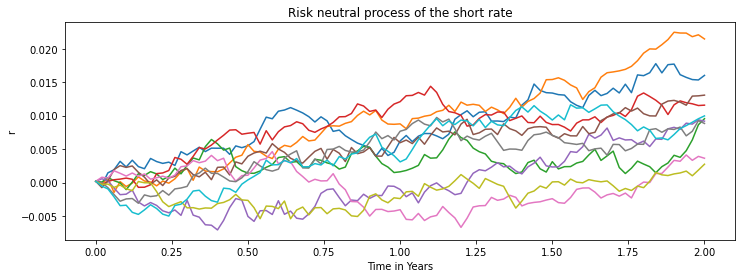

In [5]:
plt.figure(figsize=(12,4))
for i in range(10):
    a = model.generate_short_rate(2)
    plt.plot(a[0],a[1])
plt.xlabel('Time in Years')
plt.ylabel('r')
plt.title('Risk neutral process of the short rate')

In [6]:
print('------------------- Zero Prices --------------------')
print('')
print('Time\t','Actual  \t','Analytic  \t','MonteCarlo')
for i in range(10):
    print(model.yield_curve[0][i],'\t',
          '%.4f'%model.zero_actual[i],'\t',
         '%.4f'%model.compute_zero_analytic(model.yield_curve[0][i],model.l),
         '\t','%.4f'%model.compute_zero_MC(0,model.yield_curve[0][i])[0])


------------------- Zero Prices --------------------

Time	 Actual  	 Analytic  	 MonteCarlo
0.25 	 1.0000 	 0.9998 	 0.9998
0.5 	 0.9998 	 0.9992 	 0.9992
1.0 	 0.9995 	 0.9971 	 0.9968
2.0 	 0.9968 	 0.9896 	 0.9893
3.0 	 0.9904 	 0.9784 	 0.9788
5.0 	 0.9608 	 0.9480 	 0.9449
7.0 	 0.9149 	 0.9111 	 0.9077
10.0 	 0.8496 	 0.8503 	 0.8532
20.0 	 0.6440 	 0.6529 	 0.6528
30.0 	 0.4986 	 0.4949 	 0.4967


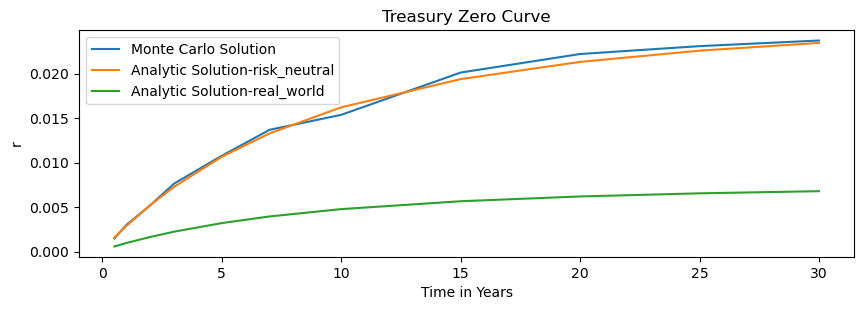

In [7]:
t =[0.5,1,2,3,5,7,10,15,20,25,30]
yield_curve_analytic=[-np.log(model.compute_zero_analytic(i,l=model.l))/i for i in t]
yield_curve_real = [-np.log(model.compute_zero_analytic(i,l=0))/i for i in t]
yield_curve_MC = [-np.log(model.compute_zero_MC(0,i)[0])/i for i in t]

plt.figure(figsize=(10,3),dpi=100)
plt.plot(t,yield_curve_MC,label='Monte Carlo Solution')
plt.plot(t,yield_curve_analytic,label='Analytic Solution-risk_neutral')
plt.plot(t,yield_curve_real,label='Analytic Solution-real_world')


plt.xlabel('Time in Years')
plt.ylabel('r')
plt.title('Treasury Zero Curve')
plt.legend()


**Pricing Interest Rate Products:**

1. Price a Coupon bond with 3 years to maturity paying 2% coupon semianually.

In [8]:
T=3
c = 0.02
time = np.arange(0.5,3.1,0.5)
cf = np.array([c*100/2 for i in range(len(time))])
cf[-1]=cf[-1]+100
df = np.array([model.compute_zero_analytic(i,model.l) for i in time])
coupon_bond_price = sum(df*cf)
print('The price of the coupon bond is',np.round(coupon_bond_price,3))

The price of the coupon bond is 103.778


2. Calculate the 3-yr Treasury swap rate with interest paid semi-anually. Assume the swap starts after one year.

In [9]:
dt = 0.5
time = np.arange(0.5,3.1,0.5)+1
df = np.array([model.compute_zero_analytic(i,model.l) for i in time])
df_1 = model.compute_zero_analytic(1,model.l)
s = (df_1-df[-1])/(sum(dt*df))
print('The 3-yr swap rate after 1 year is','%.4f'%s)

The 3-yr swap rate after 1 year is 0.0112


In [10]:
#Alternative approach using Monte Carlo:
dt = 0.5
time = np.arange(0.5,3.1,0.5)+1
df = np.array([model.compute_zero_MC(1,i)[0] for i in time])
s = (1-df[-1])/(sum(dt*df))
print('The 3-yr swap rate after 1 year is','%.4f'%s)

The 3-yr swap rate after 1 year is 0.0117


Both the approaches provide the same value.

3. Price a call and put option on a zero coupon bond with strike price K = 98. The time to maturity of the bond is 5 years and the time to expiry of the option is 3 years.

In [11]:
T= 5
t =3
n = 100
dt = T/n
K = 98
t_loc = int(t/dt)
prices=[]
for x in range(1000):
    price =1
    r = model.generate_short_rate(T,n)
    price = np.exp(-sum(np.array(r[1][t_loc+1:])*dt))
    prices.append(price)

call_payoffs = np.maximum(np.array(prices)*100-K,0)
put_payoffs = np.maximum(K-np.array(prices)*100,0)

call_value = np.mean(call_payoffs*model.compute_zero_analytic(t,l=model.l))
put_value = np.mean(put_payoffs*model.compute_zero_analytic(t,l=model.l))
   
print('The value of the call option is %.4f'%call_value)
print('The value of the put option is %.4f'%put_value)

The value of the call option is 0.2033
The value of the put option is 1.3398


4. Price a call and put option on a coupon bond with strike price K = 105. The time to maturity of the bond is 5 years and the time to expiry of the option is 3.2 years. The coupon rate is 3% paid semi-annually.

In [12]:
T= 5
coupon_dates = [3.5,4,4.5,5]
cf = [1.5,1.5,1.5,101.5]
t =3.2
n = 100
dt = T/n
K = 105

prices=[]
call_payoffs=[]
put_payoffs =[]
t_loc = int(t/dt)
coupon_loc = list(map(lambda x: int(x/dt),coupon_dates))

for x in range(1000):
    price =0
    r = model.generate_short_rate(T,n)
    for y in reversed(range(len(coupon_dates))):
        c = cf[y]*np.exp(-sum(np.array(r[1][t_loc+1:coupon_loc[y]+1])*dt))
        price = price+c
    call_payoff = np.maximum(price-K,0)
    put_payoff = np.maximum(K-price,0)
    
    call_payoff = call_payoff*np.exp(-sum(np.array(r[1][1:t_loc+1])*dt))
    put_payoff = put_payoff*np.exp(-sum(np.array(r[1][1:t_loc+1])*dt))
    
    call_payoffs.append(call_payoff)
    put_payoffs.append(put_payoff)
    #prices.append(price)
    
#call_payoffs = np.maximum(np.array(prices)-K,0)
#put_payoffs = np.maximum(K-np.array(prices),0)

#call_value = np.mean(call_payoffs*model.compute_zero_analytic(t,l=model.l))
call_value = np.mean(call_payoffs)
put_value = np.mean(put_payoffs)
#put_value = np.mean(put_payoffs*model.compute_zero_analytic(t,l=model.l))
   
print('The value of the call option is %.4f'%call_value)
print('The value of the put option is %.4f'%put_value)    


The value of the call option is 0.0592
The value of the put option is 1.9696


5. Price a cap and floor on floating interest payments on a loan of $1000 with 15 years to maturity and payments done every  year. Cap = 2.5% and floor = 1%.

In [100]:
L = 1000
T = 15
payment_dates = [x for x in range(1,13)]
cap =0.025
floor = 0.01
cap_payoffs =[]
floor_payoffs =[]

for i in range(1000):
    r = model.generate_short_rate(12,120)
    dt = r[0][1]-r[0][0]
    cap_payoff = 0
    floor_payoff =0
    for x in payment_dates:
        t1_loc = r[0].index(x-1)
        t2_loc = r[0].index(x)
        df = np.exp(-sum(np.array(r[1][0:t2_loc])*dt))
        y = sum(np.array(r[1][t1_loc:t2_loc])*dt)/(1)
        cap_payoff = cap_payoff+np.maximum(y-cap,0)*df*L*1
        floor_payoff = floor_payoff + np.maximum(floor-y,0)*df*L*1
    cap_payoffs.append(cap_payoff)
    floor_payoffs.append(floor_payoff)
    
cap_value = np.mean(cap_payoffs)
floor_value = np.mean(floor_payoffs)

print("The value of the cap is %.4f"%cap_value)
print("The value of the floor is %.4f"%floor_value)

The value of the cap is 17.8180
The value of the floor is 18.3618


6. Price a swaption to enter into a 3-treasury swap with payments done semi-annually. The option expires after 1 year. Strike Price = 1%

In [171]:
K = 0.01
L=1000
time = np.arange(0.5,3.1,0.5)+1
payoffs =[]

for i in range(1000):
    r = model.generate_short_rate(4,200)
    dt = r[0][1]-r[0][0]
    df =[]
    for t in time:
        df.append(np.exp(-sum(np.array(r[1][r[0].index(1):r[0].index(t)])*dt)))
    s = (1-df[-1])/sum(np.array(df)*0.5)
    df_0 = np.exp(-sum(np.array(r[1][0:r[0].index(1)])*dt))
    payoff = np.maximum(s-K,0)*1000*0.5*sum(df)*df_0
    payoffs.append(payoff)

val = np.mean(payoffs)
print('The value of the swaption is %.4f'%val)

The value of the swaption is 9.3422
